## GRCh38 new selfChain and Segdups

This notebook shows the process to generate a new chainSelf file for GRCh38 using `chainSelf.txt.gz` and `chainSelfLink.txt.gz` from the UCSC table browser. This process also uses Aaron Wegners (PacBio) script `hg38.README_annotation.md` (5/22/19)

UCSC files previously downloaded can be obtained using the following commands:
rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg38/database/chainSelf.txt.gz
rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg38/database/chainSelfLink.txt.gz

Note: this process was first run by JM with shell script `Aaron_hg38_step_by_step.sh`. All output files from what was called the "DM" run for datamash, are found in /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/Files_from_DM_selfchain_prep

**Working Directory** `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains`

#### Summary of Process

**1. Pre-processing**

UCSC chainSelf/Link --> remove trivial (chainSelf only) (GRCh38 does not contain alternate loci)

**2. Run Aaron Script to generate selfchain**

**3. Post-Process selfchain**

selfchain --> sort/remove non 1-22,XY --> merge -d100 --> filter merged >10kb --> sum regions

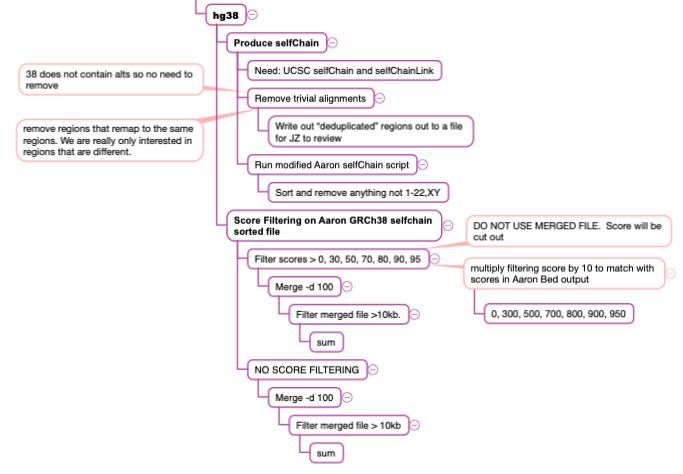

In [2]:
display < ./img/GRCh38_chainSelf_process.png

Note on above graphic: Filtering by selfchain score was done to evaluate how similar 38 process to generate selfchain was to 37.  The files generated in this notebook are not score filtered.

### 1) Remove Trivial Regions
This step will remove "trivial" regions, aka regions that map to themselves.

In [11]:
gzcat GRCh38_chainSelf.txt.gz | awk '$3!=$7 || $5!=$10' | bgzip > GRCh38_chainSelf_notrivial.txt.gz

note regarding GRCh38_chainSelf_notrivial.txt.gz:  I had to re-run the above code because the file was trucated, only went to chr16.  Found this out becauase I had produced this file previously in "DM" run and the file was much larger.  There was no warning in the notebook there was an interruption.  I do see in the terminalnot ebook not trusted and kernel interrupted messages that might have led to the issue but not sure that occured during the run of this command. I did not see the issue until the next day when I needed to use this file in Aaron's script. After re-running file size is the same as previous "DM" run.

### 2) Run Aaron Script
code below is modified version of Aaron's selfchain preparation in `hg.38.README_annotation.md`. His script was broken in to smaller chunks to monitor running and eliminate some issues with running from terminal on the Mac.

In [5]:
echo "intermediate" `date`
gzcat GRCh38_chainSelfLink.txt.gz | awk '{ print $6 "\t" $3 "\t" $4 "\t" $5 "\t" $5+$4-$3; }' | sort -k1,1 -k2,2g > ./script_intermediates/38_chainSelfLink_intermediate.bed
echo "finished 38_chainSelfLink_intermediate.bed" `date`

intermediate Mon Sep 9 13:11:53 EDT 2019
finished 38_chainSelfLink_intermediate.bed Mon Sep 9 15:49:44 EDT 2019


In [7]:
echo "began intermediate at" `date`
gzcat GRCh38_chainSelfLink.txt.gz | 
	awk '{ print $6 "\t" $3 "\t" $4; }' | 
	bedtools merge -d 100 -i stdin | 
	sort -k1,1 -k2,2g |
   bedtools intersect -sorted -wa -wb -a stdin -b ./script_intermediates/38_chainSelfLink_intermediate.bed|
	sort -k1,1 -k2,2 -k3,3 | 
	datamash -g1,2,3 min 7 max 8  > ./script_intermediates/38_datamash_intermediate.bed
echo "finished 38_datamash_intermediate.bed" `date`

began intermediate at Mon Sep 9 16:13:49 EDT 2019
finished 38_datamash_intermediate.bed Mon Sep 9 19:43:06 EDT 2019


In [12]:
echo "began intermediate at" `date`
gzcat GRCh38_chainSelf_notrivial.txt.gz | awk '{ print $12 "\t" $3 "\t" $7 "\t" $8 "\t" $9 "\t" $13; }' | sort -k1,1 > ./script_intermediates/38_chainSelf_intermediate.bed
echo "finished 38_chainSelf_intermediate.bed at" `date`

began intermediate at Tue Sep 10 10:49:05 EDT 2019
finished 38_chainSelf_intermediate.bed at Tue Sep 10 11:33:49 EDT 2019


In [13]:
echo "began join at" `date`
join -t $'\t' ./script_intermediates/38_datamash_intermediate.bed ./script_intermediates/38_chainSelf_intermediate.bed > ./script_intermediates/38_joined_intermediate.bed
echo "join done at" `date`

began join at Tue Sep 10 11:35:31 EDT 2019
join done at Tue Sep 10 11:46:21 EDT 2019


In [14]:
echo "began at" `date`
awk '{ qs=($9=="+")?$4:$8-$5; qe=($9=="+")?$5:$8-$4; printf "%s\t%d\t%d\t%s:%'\''d-%'\''d\t%s\t%d\n", $6, $2, $3, $7, qs+1, qe, $9, int(10*$10); }' ./script_intermediates/38_joined_intermediate.bed | sort -k1,1 -k2,2g | bgzip -c > /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/annotation/GRCh38_Aaron_code_chainSelf.bed.gz 
tabix -f ./annotation/GRCh38_Aaron_code_chainSelf.bed.gz
echo "finished GRCh38_Aaron_code_chainSelf.bed.gz at" `date`

began at Tue Sep 10 11:49:07 EDT 2019
finished GRCh38_Aaron_code_chainSelf.bed.gz at Tue Sep 10 13:19:13 EDT 2019


In [15]:
md5 ./annotation/GRCh38_Aaron_code_chainSelf.bed.gz

MD5 (./annotation/GRCh38_Aaron_code_chainSelf.bed.gz) = 6c7dcf1f3d9159f0e8846e2c06eae299


### 3) Selfchain post processing
post processing done to remove undesired chromosomes/contigs, merge and filter regions to >10kb

**check to see if any extra chrom/contigs need to be removed.  Only want 1-22, XY**

In [16]:
gzcat ./annotation/GRCh38_Aaron_code_chainSelf.bed.gz | cut -f 1 | uniq

chr1
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr2
chr20
chr21
chr22
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrM
chrX
chrY


**Remove non 1-22, XY chromosomes, in this case only "M", and sort**

In [19]:
gzcat ./annotation/GRCh38_Aaron_code_chainSelf.bed.gz | sed 's/^chr//' | grep -v '^M' | sed 's/^X/23/;s/^Y/24/' | sort -k1,1n -k2,2n | sed 's/^23/X/;s/^24/Y/'| sed 's/^/chr/' | bgzip > ./annotation/GRCh38_Aaron_code_chainSelf_sorted.bed.gz 

**Merge Regions**  
This processs will merge regions with maximum distance of 100 bps  
Note: filenames changed as this will be a distributed outputfile, "Aaron_code" removed from filename

In [20]:
gzcat ./annotation/GRCh38_Aaron_code_chainSelf_sorted.bed.gz| bedtools merge -i stdin -d 100 | bgzip > ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz

**Merged line count and regions sum for merged output file**

In [21]:
gzcat ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz | wc -l
gzcat ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

  149284
208467442


**Filter to regions > 10kb**

In [22]:
gzcat ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz | awk '($3-$2 > 10000)' | bgzip > ./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz

**Merged line count and regions sum for filtered fle**

In [23]:
gzcat ./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz | wc -l
gzcat ./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    2011
109954753


## Segdups
JZ would like to use segmental duplications file in conjunction with self chains. In evaluation of selfchain with Segdups it appears the selfchain is missing several segmental duplications.  Like self chain, this file will be merged and filtered to regions >10kb.  The starting file `segdups.bed.gz` was generated by Aaron Wegner (PacBio) using his script `hg38.README_annotation.md`

UCSC Segdups file was downloaded from:
rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg38/database/genomicSuperDups.txt.gz

**Summary of Processing**  
segdups.bed.gz -->  sort/remove non 1-22,XY --> merge -d100 --> filter merged >10kb

In [25]:
gzcat hg38.segdups.bed.gz | cut -f 1 | grep -E "_|chr[a-zA-Z]"| uniq

chr11_KI270721v1_random
chr14_GL000009v2_random
chr14_GL000194v1_random
chr14_GL000225v1_random
chr14_KI270722v1_random
chr14_KI270723v1_random
chr14_KI270724v1_random
chr14_KI270725v1_random
chr14_KI270726v1_random
chr15_KI270727v1_random
chr16_KI270728v1_random
chr17_GL000205v2_random
chr17_KI270729v1_random
chr17_KI270730v1_random
chr1_KI270706v1_random
chr1_KI270707v1_random
chr1_KI270708v1_random
chr1_KI270709v1_random
chr1_KI270710v1_random
chr1_KI270711v1_random
chr1_KI270712v1_random
chr1_KI270713v1_random
chr1_KI270714v1_random
chr22_KI270731v1_random
chr22_KI270732v1_random
chr22_KI270733v1_random
chr22_KI270734v1_random
chr22_KI270735v1_random
chr22_KI270736v1_random
chr22_KI270737v1_random
chr22_KI270738v1_random
chr3_GL000221v1_random
chr4_GL000008v2_random
chr5_GL000208v1_random
chr9_KI270717v1_random
chr9_KI270718v1_random
chr9_KI270719v1_random
chr9_KI270720v1_random
chrM
chrUn_GL000195v1
chrUn_GL000213v1
chrUn_GL000214v1
chrUn_GL000216v2
chrUn_GL000218v1
chrUn_GL000219

#### Remove non 1-22, XY chromosomes (Remove chrM, chr#, chr## and chrUn) and sort.

In [26]:
gzcat hg38.segdups.bed.gz | sed 's/^chr//' | grep -Ev '^M|^[0-9][0-9]_|[0-9]_|^Un' | sed 's/^X/23/;s/^Y/24/' | sort -k1,1n -k2,2n | sed 's/^23/X/;s/^24/Y/'| sed 's/^/chr/' | bgzip > ./new_segdups/hg38.segdups_sorted.bed.gz

count lines removed

In [30]:
gzcat hg38.segdups.bed.gz | wc -l
gzcat ./new_segdups/hg38.segdups_sorted.bed.gz | wc -l

   69894
   61153


In [31]:
echo $((69894-61153))

8741


removal of extra chrom/contigs removed 8741 lines (locations)

#### **Merge Regions**  
This processs will merge regions with maximum distance of 100 bps

In [32]:
gzcat ./new_segdups/hg38.segdups_sorted.bed.gz | bedtools merge -i stdin -d 100 | bgzip > ./new_segdups/hg38.segdups_sorted_merged.bed.gz

Stats before merging (line count, regions sum)

In [33]:
gzcat ./new_segdups/hg38.segdups_sorted.bed.gz | wc -l
gzcat ./new_segdups/hg38.segdups_sorted.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

   61153
762646428


Stats after merging (line count, regions sum)

In [34]:
gzcat ./new_segdups/hg38.segdups_sorted_merged.bed.gz | wc -l
gzcat ./new_segdups/hg38.segdups_sorted_merged.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    7401
166497144


#### Filter to regions > 10kb

In [35]:
gzcat ./new_segdups/hg38.segdups_sorted_merged.bed.gz| awk '($3-$2 > 10000)' | bgzip > ./new_segdups/hg38.segdups_sorted_merged_gt10kb.bed.gz

Stats after filtering (line count, regions sum)

In [36]:
gzcat ./new_segdups/hg38.segdups_sorted_merged_gt10kb.bed.gz | wc -l
gzcat ./new_segdups/hg38.segdups_sorted_merged_gt10kb.bed.gz | awk '{ sum+=$3;sum-=$2 } END { print sum }'

    1828
151537252


## Create "notin" files

In [1]:
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.hg38.1_22XY.genome.sorted.bed -b ./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz | bgzip > ./annotation/GRCh38_notinchainSelf_sorted_merged_gt10kb.bed.gz
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.hg38.1_22XY.genome.sorted.bed -b ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz | bgzip > ./annotation/GRCh38_notinchainSelf_sorted_merged.bed.gz 
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.hg38.1_22XY.genome.sorted.bed -b ./new_segdups/hg38.segdups_sorted_merged_gt10kb.bed.gz | bgzip > ./new_segdups/hg38.notinsegdups_sorted_merged_gt10kb.bed.gz
subtractBed -a /Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_stratification_validation/data/stratifications/reference_beds/intermediates/human.hg38.1_22XY.genome.sorted.bed -b ./new_segdups/hg38.segdups_sorted_merged.bed.gz | bgzip > ./new_segdups/hg38.notinsegdups_sorted_merged.bed.gz

## md5 checksums

In [3]:
md5 ./annotation/GRCh38_chainSelf_sorted_merged.bed.gz
md5 ./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz
md5 ./new_segdups/hg38.segdups_sorted_merged.bed.gz
md5 ./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz
md5 ./annotation/GRCh38_notinchainSelf_sorted_merged.bed.gz
md5 ./annotation/GRCh38_notinchainSelf_sorted_merged_gt10kb.bed.gz
md5 ./new_segdups/hg38.notinsegdups_sorted_merged.bed.gz
md5 ./new_segdups/hg38.notinsegdups_sorted_merged_gt10kb.bed.gz

MD5 (./annotation/GRCh38_chainSelf_sorted_merged.bed.gz) = 64951ab6aba2b8eb95c82255a4702432
MD5 (./annotation/GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz) = ffaeec5872873e78b9ac9b78b73dbfe2
MD5 (./new_segdups/hg38.segdups_sorted_merged.bed.gz) = 8fa70cfa2ca924ba4f8b19c160409938
MD5 (./new_segdups/hg19.segdups_sorted_merged_gt10kb.bed.gz) = ff88d362fb0ba763b52defdb300a4849
MD5 (./annotation/GRCh38_notinchainSelf_sorted_merged.bed.gz) = e9255bb4de1fb26d03085ebb7db39830
MD5 (./annotation/GRCh38_notinchainSelf_sorted_merged_gt10kb.bed.gz) = bdbb1fe76618548154b29e49cc1b965e
MD5 (./new_segdups/hg38.notinsegdups_sorted_merged.bed.gz) = cee634060573f7e02656f248a3fcc3c0
MD5 (./new_segdups/hg38.notinsegdups_sorted_merged_gt10kb.bed.gz) = 59969d0341d45c2414f0013d81497853


## New GRCh38 SelfChain and Segdup Output files
chainself files on JM computer in `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/annotation`

sedup files on JM computer in `/Users/jmcdani/Documents/GiaB/Benchmarking/GRCh38_beds/selfchain/new_selfchains/new_segdups`

|File|note|md5|File Size|Date Generated|
|-|-|-|-|-|
|GRCh38_chainSelf_sorted_merged_gt10kb.bed.gz|excludes regions < 10kb|ffaeec5872873e78b9ac9b78b73dbfe2|19 KB    |09/10/19|
|GRCh38_chainSelf_sorted_merged.bed.gz       |contains regions < 10kb|64951ab6aba2b8eb95c82255a4702432|1.2 MB   |09/10/19|
|hg38.segdups_sorted_merged_gt10kb.bed.gz|excludes regions < 10kb|7be830299a74a987dabc0457839cb4f3|18 KB| 09/10/19|
|hg38.segdups_sorted_merged.bed.gz|contains regions < 10kb|8fa70cfa2ca924ba4f8b19c160409938|69 KB|09/10/19|
|GRCh38_notinchainSelf_sorted_merged.bed.gz|notin| e9255bb4de1fb26d03085ebb7db39830|19 KB|12/11/19|
|GRCh38_notinchainSelf_sorted_merged_gt10kb.bed.gz |notin| bdbb1fe76618548154b29e49cc1b965e|1.2 MB|12/11/19|
|hg38.notinsegdups_sorted_merged.bed.gz |notin| cee634060573f7e02656f248a3fcc3c0|70 KB|12/11/19|
|hg38.notinsegdups_sorted_merged_gt10kb.bed.gz |notin| 59969d0341d45c2414f0013d81497853|18 KB|12/11/19|